In [1]:
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import re
import string
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

In [3]:
from nltk import pos_tag

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,ConfusionMatrixDisplay, accuracy_score

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

In [8]:
from textblob import TextBlob
import textstat

In [9]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Nandita\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [10]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nandita\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
nltk.download("averaged_perceptron_tagger_eng")

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Nandita\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [11]:
nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Nandita\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [12]:
from nltk.corpus import stopwords

In [13]:
import psycopg2

In [14]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [15]:
from scipy.sparse import hstack,csr_matrix,issparse

In [16]:
load_dotenv()

True

In [17]:
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_NAME = os.getenv("DB_NAME")
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")

In [18]:
DATABASE_URL = f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"

In [19]:
engine = create_engine(DATABASE_URL)

In [20]:
train_df = pd.read_sql("SELECT * FROM train_data", engine)

In [21]:
train_df.head()

,id,subject,body,text,category,category_id
0,promotions_582,Anniversary Special: Buy one get one free,"As our loyal customer, get exclusive $60 off $...",Anniversary Special: Buy one get one free As o...,promotions,1
1,spam_1629,Your Amazon was used on new device,Your $5000 refund is processed. Claim: bit.ly/...,Your Amazon was used on new device Your $5000 ...,spam,3
2,spam_322,Re: Your Google inquiry,"Hi, following up about your Google application...","Re: Your Google inquiry Hi, following up about...",spam,3
3,social_media_80,Digital Ritual Experience Creation,Cross-cultural ceremony design. Join: virtualr...,Digital Ritual Experience Creation Cross-cultu...,social_media,2
4,forum_1351,"Your post was moved to ""Programming Help""","Trending: ""cooking"" (258 comments). View: supp...","Your post was moved to ""Programming Help"" Tren...",forum,0


In [22]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10780 entries, 0 to 10779
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           10780 non-null  object
 1   subject      10780 non-null  object
 2   body         10780 non-null  object
 3   text         10780 non-null  object
 4   category     10780 non-null  object
 5   category_id  10780 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 505.4+ KB


In [23]:
train_df.shape

(10780, 6)

In [24]:
train_df['category'].value_counts()

category
verify_code     1800
forum           1800
social_media    1796
promotions      1796
spam            1794
updates         1794
Name: count, dtype: int64

In [25]:
def clean_texts(col): 
    col = col.lower() 
    col = re.sub(r"\d+", " num ", col)  
    col = re.sub(r"[^\w\s!?]", "", col)  
    col = " ".join([word for word in col.split() if word not in stopwords.words('english')])  
    return col

In [26]:
def add_features(df):
    punctuations = ["!", "?", "...", "$", "%", "#", "*"]
    
    for col in ['subject', 'body', 'text']:
        # Character length
        df[f'{col}_char_len'] = df[col].apply(len)
        
        # Word length
        df[f'{col}_word_len'] = df[col].apply(lambda x: len(x.split()))
        
        # Sentence length
        df[f'{col}_sent_len'] = df[col].apply(lambda x: len(sent_tokenize(x)))
        
        # Avg word length
        df[f'{col}_avg_word_len'] = df[col].apply(
            lambda x: np.mean([len(w) for w in x.split()]) if len(x.split()) > 0 else 0
        )
        
        # Punctuation counts
        for p in punctuations:
            safe_p = re.escape(p)  # escape $, *, ...
            df[f"{col}_{p}_count"] = df[col].str.count(safe_p)
        
        # Uppercase ratio
        df[f'{col}_upper_ratio'] = df[col].apply(
            lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0
        )
        
        # Digit count
        df[f'{col}_digit_count'] = df[col].apply(lambda x: sum(c.isdigit() for c in x))
    
    return df

In [27]:
train_df['combined_text_original'] = train_df['subject']+ " " +train_df['body']+ " " +train_df['text'] 

In [28]:
train_df['combined_text_original'][2]

'Re: Your Google inquiry Hi, following up about your Google application. Rates dropped to 0.9%! Apply now: phishing-site.com. STOP to opt out. Re: Your Google inquiry Hi, following up about your Google application. Rates dropped to 0.9%! Apply now: phishing-site.com. STOP to opt out.'

In [29]:
train_df['combined_text_normalized'] = train_df['combined_text_original'].astype(str).apply(clean_texts)

In [30]:
train_df['combined_text_normalized'][2]

'google inquiry hi following google application rates dropped num num ! apply phishingsitecom stop opt google inquiry hi following google application rates dropped num num ! apply phishingsitecom stop opt'

In [31]:
def get_train_test(X, y, test_size=0.2, random_state=101):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        stratify=y   
    )
    return X_train, X_test, y_train, y_test

In [32]:
def convert_to_tfidf_vectorizer(df, text_col, max_features=5000, ngram_range=(1,2)):
    df = df.copy()
    vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range)
    X_tfidf = vectorizer.fit_transform(df[text_col])
    
    return X_tfidf, vectorizer

In [33]:
def combine_features(X_tfidf, engineered_features):
    if not issparse(engineered_features):
        engineered_features = engineered_features.values
    
    return hstack([X_tfidf, engineered_features])

In [34]:
def get_all_feature_names(tfidf_vectorizer, engineered_features):
    tfidf_features = tfidf_vectorizer.get_feature_names_out()
    engineered_features_cols = engineered_features.columns
    return np.concatenate([tfidf_features, engineered_features_cols])

In [35]:
def run_logistic_regression(X_train, X_test, y_train, y_test, feature_names=None):
    clf = LogisticRegression(max_iter=2000, solver='lbfgs', multi_class='multinomial')  
    clf.fit(X_train, y_train)

    # Predictions
    y_pred = clf.predict(X_test)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    print(f"\n🔹 Accuracy: {acc:.4f}\n")

    # Classification Report
    print("🔹 Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.show()

    # Feature Importance
    if feature_names is not None:
        print("\n🔹 Top Features per Class:\n")
        for i, class_label in enumerate(clf.classes_):
            coef = clf.coef_[i]
            top_pos_idx = coef.argsort()[-10:][::-1]
            top_neg_idx = coef.argsort()[:10]

            print(f"\nClass: {class_label}")
            print("  Top Positive Features:")
            for idx in top_pos_idx:
                print(f"    {feature_names[idx]}: {coef[idx]:.4f}")

            print("  Top Negative Features:")
            for idx in top_neg_idx:
                print(f"    {feature_names[idx]}: {coef[idx]:.4f}")

    return clf


In [36]:
df1 = train_df.copy()

In [37]:
df1 = add_features(df1)

In [38]:
X_1 = df1.drop(['category','category_id'],axis=1)

In [39]:
y_1 = df1['category_id']

In [40]:
X_train, X_test, y_train, y_test = get_train_test(X_1, y_1, test_size=0.2, random_state=101)

In [41]:
X_train_tfidf,vetorizer = convert_to_tfidf_vectorizer(X_train,'combined_text_normalized', max_features=10000, ngram_range=(1,2))

In [42]:
X_test_tfidf = vetorizer.transform(X_test['combined_text_normalized'])

In [43]:
engineered_features =  X_train.loc[:, "subject_char_len":]

In [44]:
engineered_features_test = X_test.loc[:,"subject_char_len":]

In [45]:
train_features =  get_all_feature_names(vetorizer, engineered_features)

In [46]:
X_train_1 = combine_features(X_train_tfidf,engineered_features)

In [47]:
X_test_1 = combine_features(X_test_tfidf,engineered_features_test)

D:\MiniForge\envs\email_classification_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
D:\MiniForge\envs\email_classification_env\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



🔹 Accuracy: 0.9680

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       360
           1       0.97      0.97      0.97       359
           2       0.96      0.96      0.96       359
           3       0.99      0.96      0.97       359
           4       0.97      0.97      0.97       359
           5       0.99      0.98      0.99       360

    accuracy                           0.97      2156
   macro avg       0.97      0.97      0.97      2156
weighted avg       0.97      0.97      0.97      2156



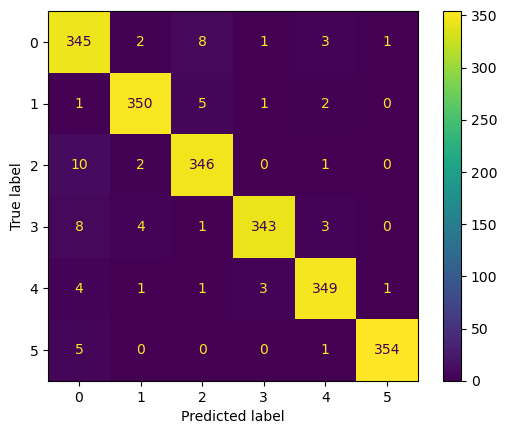


🔹 Top Features per Class:


Class: 0
  Top Positive Features:
    thread: 2.1754
    forumcomthread num: 1.9051
    forumcomthread: 1.9051
    wikisitepage num: 1.8430
    wikisitepage: 1.8430
    forum: 1.8250
    supportsiteticket: 1.6893
    supportsiteticket num: 1.6893
    discussion: 1.4442
    achievement: 1.4406
  Top Negative Features:
    body_!_count: -2.5421
    body_$_count: -1.5159
    text_!_count: -1.1841
    text_$_count: -1.0604
    text_avg_word_len: -1.0246
    num num: -1.0093
    body_upper_ratio: -0.9289
    text_?_count: -0.8629
    group: -0.8150
    subject_#_count: -0.7787

Class: 1
  Top Positive Features:
    text_%_count: 2.8104
    text_$_count: 2.3583
    shop: 1.9519
    examplecom: 1.9374
    examplecom num: 1.9374
    subject_$_count: 1.9229
    body_%_count: 1.8572
    shop examplecom: 1.7045
    free: 1.6689
    deal: 1.3442
  Top Negative Features:
    text_#_count: -1.2019
    body_#_count: -0.8233
    view: -0.7839
    alert: -0.7593
    see: -0

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,2000
,multi_class,'multinomial'


In [48]:
run_logistic_regression(X_train_1, X_test_1, y_train, y_test, feature_names=train_features)

#### Adding bigrams,trigrams and parts of speech with Tf-Idf

In [49]:
def get_pos_tags(text):
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    return " ".join([tag for _, tag in pos_tags])

In [51]:
df1["parts_of_speech"] = df1["combined_text_normalized"].apply(get_pos_tags)

In [52]:
df1.head()

,id,subject,body,text,category,category_id,combined_text_original,combined_text_normalized,subject_char_len,subject_word_len,...,text_!_count,text_?_count,text_..._count,text_$_count,text_%_count,text_#_count,text_*_count,text_upper_ratio,text_digit_count,parts_of_speech
0,promotions_582,Anniversary Special: Buy one get one free,"As our loyal customer, get exclusive $60 off $...",Anniversary Special: Buy one get one free As o...,promotions,1,Anniversary Special: Buy one get one free As o...,anniversary special buy one get one free loyal...,41,7,...,0,0,0,2,0,0,0,0.090909,10,JJ JJ VB CD NN CD JJ NN NN VBP JJ NN NN NN NN ...
1,spam_1629,Your Amazon was used on new device,Your $5000 refund is processed. Claim: bit.ly/...,Your Amazon was used on new device Your $5000 ...,spam,3,Your Amazon was used on new device Your $5000 ...,amazon used new device num refund processed cl...,34,7,...,0,0,0,1,0,0,0,0.043103,6,NNS VBD JJ NN NN NN VBD NN NN JJ IN JJ NN NN V...
2,spam_322,Re: Your Google inquiry,"Hi, following up about your Google application...","Re: Your Google inquiry Hi, following up about...",spam,3,"Re: Your Google inquiry Hi, following up about...",google inquiry hi following google application...,23,4,...,1,0,0,0,1,0,0,0.078014,2,NN NN NN VBG JJ NN NNS VBD JJ NN . VB JJ NN NN...
3,social_media_80,Digital Ritual Experience Creation,Cross-cultural ceremony design. Join: virtualr...,Digital Ritual Experience Creation Cross-cultu...,social_media,2,Digital Ritual Experience Creation Cross-cultu...,digital ritual experience creation crosscultur...,34,4,...,0,0,0,0,0,0,0,0.058333,0,JJ JJ NN NN JJ NN NN NN NN JJ NN JJ JJ NN NN J...
4,forum_1351,"Your post was moved to ""Programming Help""","Trending: ""cooking"" (258 comments). View: supp...","Your post was moved to ""Programming Help"" Tren...",forum,0,"Your post was moved to ""Programming Help"" Tren...",post moved programming help trending cooking n...,41,7,...,0,0,0,0,0,0,0,0.046296,6,NN VBD VBG NN VBG VBG JJ NNS VBP NN NN NN VBD ...


In [53]:
y = df1['category_id']

In [54]:
X_text = df1['combined_text_normalized']

In [55]:
X_pos = df1['parts_of_speech']

In [56]:
X_text_train, X_text_test, y_train, y_test = get_train_test(X_text, y, test_size=0.2, random_state=101)

In [57]:
X_pos_train,X_pos_test,y_pos_train,y_pos_test = get_train_test(X_pos,y,test_size=0.2, random_state=101)

In [58]:
ngram_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(2,3))

In [59]:
bigram_trigram_train = ngram_vectorizer.fit_transform(X_text_train)

In [60]:
bigram_trigram_test = ngram_vectorizer.transform(X_text_test)

In [61]:
pos_vectorizer = CountVectorizer()

In [62]:
pos_features_train = pos_vectorizer.fit_transform(X_pos_train)

In [63]:
pos_features_test = pos_vectorizer.transform(X_pos_test)

In [64]:
X_train_combined = hstack([bigram_trigram_train, pos_features_train])
X_test_combined = hstack([bigram_trigram_test, pos_features_test])

In [65]:
all_feature_names = list(ngram_vectorizer.get_feature_names_out()) + \
                    list(pos_vectorizer.get_feature_names_out())

D:\MiniForge\envs\email_classification_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



🔹 Accuracy: 0.9680

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       360
           1       0.97      0.97      0.97       359
           2       0.96      0.97      0.97       359
           3       0.98      0.96      0.97       359
           4       0.96      0.98      0.97       359
           5       0.98      0.98      0.98       360

    accuracy                           0.97      2156
   macro avg       0.97      0.97      0.97      2156
weighted avg       0.97      0.97      0.97      2156



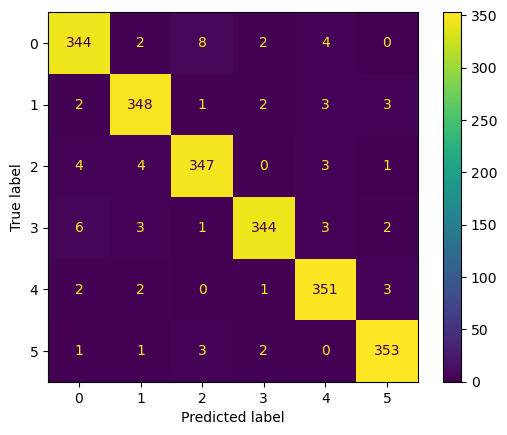


🔹 Top Features per Class:


Class: 0
  Top Positive Features:
    supportsiteticket num: 3.6697
    wikisitepage num: 3.6299
    forumcomthread num: 3.6036
    thread discussion: 1.7300
    discussion num: 1.7300
    thread discussion num: 1.7300
    starts time: 1.5852
    event starts time: 1.5852
    starts time prepare: 1.5852
    time prepare: 1.5852
  Top Negative Features:
    code num: -0.9245
    examplecom num: -0.8102
    pin num: -0.6929
    prp: -0.6371
    secure account: -0.6080
    sale num: -0.6024
    group update: -0.5955
    extra num: -0.5935
    changelog included: -0.5922
    invited rsvp: -0.5698

Class: 1
  Top Positive Features:
    examplecom num: 3.6819
    sale num: 2.1974
    extra num: 2.0804
    num examplecom num: 2.0469
    num examplecom: 2.0469
    limited stock: 1.8500
    early access: 1.7181
    examplecom num code: 1.6737
    limited edition: 1.6477
    free shipping: 1.5365
  Top Negative Features:
    code num: -0.9618
    md: -0.9445
    sep 

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,2000
,multi_class,'multinomial'


In [66]:
run_logistic_regression(X_train_combined, X_test_combined, y_train, y_test, feature_names=all_feature_names)

In [67]:
def textblob_features(text):
    blob = TextBlob(text)
    return pd.Series([blob.sentiment.polarity,blob.sentiment.subjectivity])

In [68]:
df1[['polarity','subjectivity']] = df1['combined_text_original'].apply(textblob_features)

In [69]:
df1.head(1)

,id,subject,body,text,category,category_id,combined_text_original,combined_text_normalized,subject_char_len,subject_word_len,...,text_..._count,text_$_count,text_%_count,text_#_count,text_*_count,text_upper_ratio,text_digit_count,parts_of_speech,polarity,subjectivity
0,promotions_582,Anniversary Special: Buy one get one free,"As our loyal customer, get exclusive $60 off $...",Anniversary Special: Buy one get one free As o...,promotions,1,Anniversary Special: Buy one get one free As o...,anniversary special buy one get one free loyal...,41,7,...,0,2,0,0,0,0.090909,10,JJ JJ VB CD NN CD JJ NN NN VBP JJ NN NN NN NN ...,0.363492,0.734921


In [70]:
def get_readability(text):
    flesch = textstat.flesch_reading_ease(text)
    gunning = textstat.gunning_fog(text)
    return pd.Series([flesch,gunning])

In [71]:
df1[['flesch', 'gunning_fog']] = df1['combined_text_original'].apply(get_readability)

In [72]:
analyzer = SentimentIntensityAnalyzer()

In [73]:
def vader_features(text):
    scores = analyzer.polarity_scores(text)
    return pd.Series([scores['compound'], scores['pos'], scores['neu'], scores['neg']])

In [74]:
df1[['vader_compound','vader_pos','vader_neu','vader_neg']] = df1['combined_text_original'].apply(vader_features)

In [84]:
df2 = df1[['combined_text_original','combined_text_normalized','polarity', 'subjectivity', 'flesch', 'gunning_fog']]

In [85]:
X_train, X_test, y_train, y_test = get_train_test(df2, y, test_size=0.2, random_state=101)

In [86]:
train_col_vectorized,vector = convert_to_tfidf_vectorizer(X_train,'combined_text_normalized', max_features=10000, ngram_range=(2,3))

In [87]:
test_col_vectorized = vector.transform(X_test['combined_text_normalized'])

In [88]:
X_train.drop(['combined_text_original','combined_text_normalized'],axis=1,inplace=True)

In [89]:
X_test.drop(['combined_text_original','combined_text_normalized'],axis=1,inplace=True)

In [90]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8624 entries, 646 to 1994
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   polarity      8624 non-null   float64
 1   subjectivity  8624 non-null   float64
 2   flesch        8624 non-null   float64
 3   gunning_fog   8624 non-null   float64
dtypes: float64(4)
memory usage: 336.9 KB


In [91]:
X_input_train_1 = combine_features(train_col_vectorized, X_train)

In [92]:
X_input_test_1 = combine_features(test_col_vectorized, X_test)

In [93]:
all_features_combined =  get_all_feature_names(vector, engineered_features)

D:\MiniForge\envs\email_classification_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



🔹 Accuracy: 0.9680

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       360
           1       0.97      0.96      0.97       359
           2       0.96      0.97      0.97       359
           3       0.99      0.95      0.97       359
           4       0.95      0.99      0.97       359
           5       1.00      0.98      0.99       360

    accuracy                           0.97      2156
   macro avg       0.97      0.97      0.97      2156
weighted avg       0.97      0.97      0.97      2156



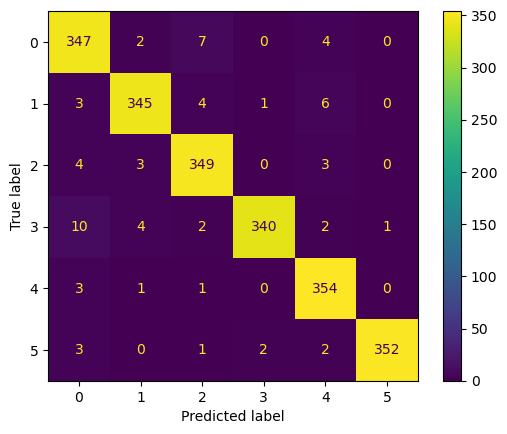


🔹 Top Features per Class:


Class: 0
  Top Positive Features:
    wikisitepage num: 4.1409
    forumcomthread num: 3.9190
    supportsiteticket num: 3.4525
    discussion num: 2.0650
    thread discussion: 2.0650
    thread discussion num: 2.0650
    comments view: 1.8036
    num comments view: 1.8036
    report num: 1.7811
    per report: 1.5880
  Top Negative Features:
    subject_char_len: -1.1042
    num num: -1.0508
    code num: -1.0325
    num num num: -0.8057
    pin num: -0.7300
    enter num: -0.6584
    num confirm: -0.6400
    suspicious activity: -0.6071
    num hrs: -0.5263
    num enter: -0.5209

Class: 1
  Top Positive Features:
    examplecom num: 3.3410
    sale num: 2.2356
    early access: 2.0989
    extra num: 1.9460
    num examplecom: 1.9030
    num examplecom num: 1.9030
    limited edition: 1.8930
    num day: 1.6866
    limited stock: 1.5739
    free shipping: 1.4987
  Top Negative Features:
    code num: -1.4671
    num num num: -1.0513
    wikisitepage num:

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,2000
,multi_class,'multinomial'


In [94]:
run_logistic_regression(X_input_train_1, X_input_test_1, y_train, y_test, feature_names=all_features_combined)

In [95]:
engineered_features_vader = df1[['flesch','gunning_fog','vader_compound', 'vader_pos',
       'vader_neu', 'vader_neg']]

In [96]:
X_train, X_test, y_train, y_test = get_train_test(engineered_features_vader, y, test_size=0.2, random_state=101)

In [97]:
X_input_train_2 = combine_features(train_col_vectorized, X_train)

In [98]:
X_input_train_3 = combine_features(test_col_vectorized, X_test)

In [99]:
all_features_combined_2 = get_all_feature_names(vector,engineered_features_vader)

D:\MiniForge\envs\email_classification_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



🔹 Accuracy: 0.9694

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       360
           1       0.96      0.97      0.97       359
           2       0.97      0.96      0.97       359
           3       0.99      0.94      0.97       359
           4       0.95      0.98      0.97       359
           5       0.99      0.98      0.99       360

    accuracy                           0.97      2156
   macro avg       0.97      0.97      0.97      2156
weighted avg       0.97      0.97      0.97      2156



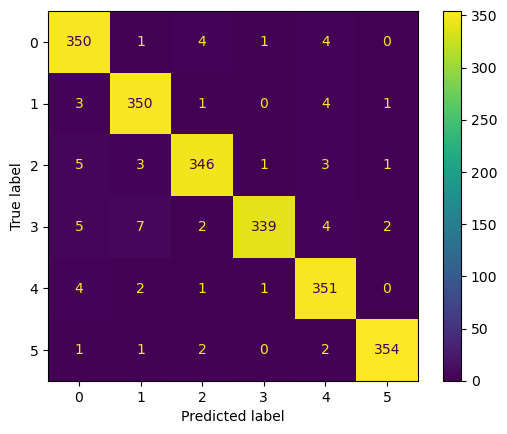


🔹 Top Features per Class:


Class: 0
  Top Positive Features:
    wikisitepage num: 4.1884
    forumcomthread num: 3.9706
    supportsiteticket num: 3.4652
    thread discussion num: 2.0759
    thread discussion: 2.0759
    discussion num: 2.0759
    report num: 1.8257
    num comments view: 1.7708
    comments view: 1.7708
    per report num: 1.5748
  Top Negative Features:
    code num: -1.0548
    num num: -1.0059
    num num num: -0.8565
    pin num: -0.7359
    vader_pos: -0.7054
    num confirm: -0.6548
    enter num: -0.6013
    view album: -0.5705
    disable notifications: -0.5423
    num min: -0.5337

Class: 1
  Top Positive Features:
    examplecom num: 3.2598
    sale num: 2.4512
    early access: 2.1724
    limited edition: 2.0064
    extra num: 2.0015
    num examplecom: 1.8649
    num examplecom num: 1.8649
    limited stock: 1.7176
    num day: 1.5214
    examplecom num code: 1.4228
  Top Negative Features:
    code num: -1.2329
    num num num: -0.9180
    vader_neu: 

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,2000
,multi_class,'multinomial'


In [100]:
run_logistic_regression(X_input_train_2, X_input_train_3, y_train, y_test, feature_names=all_features_combined_2)